## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [13]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [14]:
train, test = keras.datasets.cifar10.load_data()

In [15]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [16]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [17]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input([x_train.shape[-1]])
    for index,nuron in enumerate(num_neurons):
        if index == 0:
            x = keras.layers.Dense(units = nuron,activation = 'relu')(input_layer)
        else:
            x = keras.layers.Dense(units = nuron,activation = 'relu')(x)
        x = keras.layers.BatchNormalization()(x)
        
    output_layer = keras.layers.Dense(units = output_units,activation = 'softmax')(x)
    model = keras.models.Model(inputs = [input_layer],outputs = [output_layer])
    return model

In [18]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [22]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [.9,.75,.5]
reduce_lr_patient = [5,10,20]


In [26]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, reduce_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                 patience = reduce_patient,
                                 factor = reduce_factor,
                                 verbose = 1,
                                 min_lr = 1e-12)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    optmizer_name = lambda x : 'SGD' if x == 0 else ('Adam' if x == 1 else 'RMSprop')
    exp_name_tag = optimizer_name(i) + ',factor' + str(reduce_factor) + ',patient' + str(reduce_patient)
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.90, reduce_patient: 5
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.3063 - accuracy: 0.5468 - val_loss: 1.4788 - val_accuracy: 0.4788
Epoch 12/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2818 - accuracy: 0.5551 - val_loss: 1.4790 - val_accuracy: 0.4758
Epoch 13/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2607 - accuracy: 0.5631 - val_loss: 1.4763 - val_accuracy: 0.4763
Epoch 14/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2375 - accuracy: 0.5710 - val_loss: 1.4617 - val_accuracy: 0.4835
Epoch 15/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2165 - accuracy: 0.5789 - val_loss: 1.4749 - val_accuracy: 0.4815
Epoch 16/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.1974 - accuracy: 0.5869 - val_loss: 1.4587 - val_accuracy: 0.4855
Epoch 17/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.1775 - accuracy: 0.5939 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 70us/step - loss: 2.2518 - accuracy: 0.2590 - val_loss: 2.1769 - val_accuracy: 0.1585
Epoch 2/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.7710 - accuracy: 0.3831 - val_loss: 2.0172 - val_accuracy: 0.2416
Epoch 3/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.6357 - accuracy: 0.4258 - val_loss: 1.8459 - val_accuracy: 0.3461
Epoch 4/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.5615 - accuracy: 0.4519 - val_loss: 1.7378 - val_accuracy: 0.3853
Epoch 5/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.5036 - accuracy: 0.4702 - val_loss: 1.6447 - val_accuracy: 0.4215
Epoch 6/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.4608 - accuracy: 0.4875 - val_loss: 1.5737 - val_accuracy: 0.4488
Epoch 7/25
50000/50000 [==============================] - 3s 67us/st

Epoch 21/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.1117 - accuracy: 0.6181 - val_loss: 1.4475 - val_accuracy: 0.4953
Epoch 22/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.0938 - accuracy: 0.6244 - val_loss: 1.4468 - val_accuracy: 0.4925
Epoch 23/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.0768 - accuracy: 0.6310 - val_loss: 1.4452 - val_accuracy: 0.4963
Epoch 24/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.0624 - accuracy: 0.6367 - val_loss: 1.4477 - val_accuracy: 0.4942
Epoch 25/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.0444 - accuracy: 0.6418 - val_loss: 1.4509 - val_accuracy: 0.4906
Numbers of exp: 5, reduce_factor: 0.75, reduce_patient: 20
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)          

50000/50000 [==============================] - 3s 54us/step - loss: 1.5057 - accuracy: 0.4717 - val_loss: 1.6465 - val_accuracy: 0.4196
Epoch 6/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.4600 - accuracy: 0.4867 - val_loss: 1.5816 - val_accuracy: 0.4421
Epoch 7/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.4221 - accuracy: 0.5003 - val_loss: 1.5485 - val_accuracy: 0.4514
Epoch 8/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.3908 - accuracy: 0.5125 - val_loss: 1.5242 - val_accuracy: 0.4652
Epoch 9/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.3595 - accuracy: 0.5236 - val_loss: 1.5117 - val_accuracy: 0.4652
Epoch 10/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.3324 - accuracy: 0.5340 - val_loss: 1.4885 - val_accuracy: 0.4749
Epoch 11/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.3077 - accuracy: 0.5441 - val_loss: 1.4870 - v

50000/50000 [==============================] - 3s 64us/step - loss: 1.0453 - accuracy: 0.6426 - val_loss: 1.4456 - val_accuracy: 0.5014
Numbers of exp: 8, reduce_factor: 0.50, reduce_patient: 20
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 256)               786688    
_________________________________________________________________
batch_normalization_40 (Batc (None, 256)               1024      
_________________________________________________________________
dense_54 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_41 (Batc (None, 256)               1024      
_____________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 3s 60us/step - loss: 0.9563 - accuracy: 0.6649 - val_loss: 2.0735 - val_accuracy: 0.3821
Epoch 11/25
50000/50000 [==============================] - 3s 64us/step - loss: 0.9097 - accuracy: 0.6816 - val_loss: 1.7269 - val_accuracy: 0.4256
Epoch 12/25
50000/50000 [==============================] - 3s 67us/step - loss: 0.8665 - accuracy: 0.6971 - val_loss: 1.6023 - val_accuracy: 0.4616
Epoch 13/25
50000/50000 [==============================] - 3s 61us/step - loss: 0.8338 - accuracy: 0.7097 - val_loss: 1.7134 - val_accuracy: 0.4445
Epoch 14/25
50000/50000 [==============================] - 3s 60us/step - loss: 0.7839 - accuracy: 0.7291 - val_loss: 1.9721 - val_accuracy: 0.4169

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
Epoch 15/25
50000/50000 [==============================] - 3s 60us/step - loss: 0.7294 - accuracy: 0.7502 - val_loss: 1.7164 - val_accuracy: 0.4529
Epoch 16/25
50000/50000 [======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.8124 - accuracy: 0.3676 - val_loss: 3.5962 - val_accuracy: 0.1596
Epoch 2/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.5403 - accuracy: 0.4507 - val_loss: 1.9173 - val_accuracy: 0.3258
Epoch 3/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.4389 - accuracy: 0.4882 - val_loss: 1.7001 - val_accuracy: 0.3933
Epoch 4/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.3670 - accuracy: 0.5137 - val_loss: 1.6166 - val_accuracy: 0.4298
Epoch 5/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.3083 - accuracy: 0.5363 - val_loss: 1.6432 - val_accuracy: 0.4092
Epoch 6/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.2585 - accuracy: 0.5524 - val_loss: 1.5579 - val_accuracy: 0.4410
Epoch 7/25
50000/50000 [==============================] - 3s 60us/st

50000/50000 [==============================] - 3s 63us/step - loss: 0.6866 - accuracy: 0.7669 - val_loss: 1.4726 - val_accuracy: 0.5257
Epoch 21/25
50000/50000 [==============================] - 3s 66us/step - loss: 0.6561 - accuracy: 0.7769 - val_loss: 1.5078 - val_accuracy: 0.5092
Epoch 22/25
50000/50000 [==============================] - 3s 62us/step - loss: 0.6272 - accuracy: 0.7885 - val_loss: 1.5937 - val_accuracy: 0.4996
Epoch 23/25
50000/50000 [==============================] - 3s 60us/step - loss: 0.6016 - accuracy: 0.7989 - val_loss: 1.5951 - val_accuracy: 0.5031

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0003690562880365178.
Epoch 24/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.5511 - accuracy: 0.8189 - val_loss: 1.6462 - val_accuracy: 0.5118
Epoch 25/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.5233 - accuracy: 0.8304 - val_loss: 1.5853 - val_accuracy: 0.5141
Numbers of exp: 13, reduce_factor: 0.75, re

Epoch 4/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.2951 - accuracy: 0.5448 - val_loss: 1.5433 - val_accuracy: 0.4513
Epoch 5/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.2308 - accuracy: 0.5681 - val_loss: 1.4790 - val_accuracy: 0.4723
Epoch 6/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.1761 - accuracy: 0.5879 - val_loss: 1.5047 - val_accuracy: 0.4530
Epoch 7/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.1280 - accuracy: 0.6068 - val_loss: 1.4374 - val_accuracy: 0.4903
Epoch 8/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.0833 - accuracy: 0.6215 - val_loss: 1.4404 - val_accuracy: 0.4875
Epoch 9/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.0406 - accuracy: 0.6375 - val_loss: 1.5087 - val_accuracy: 0.4638
Epoch 10/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.0032 - accuracy: 0.6514 - val_loss: 

50000/50000 [==============================] - 3s 62us/step - loss: 0.6214 - accuracy: 0.8006 - val_loss: 1.4935 - val_accuracy: 0.5121

Epoch 00023: ReduceLROnPlateau reducing learning rate to 6.919805309735239e-05.
Epoch 24/25
50000/50000 [==============================] - 3s 60us/step - loss: 0.5859 - accuracy: 0.8173 - val_loss: 1.4532 - val_accuracy: 0.5259
Epoch 25/25
50000/50000 [==============================] - 3s 60us/step - loss: 0.5736 - accuracy: 0.8236 - val_loss: 1.4502 - val_accuracy: 0.5265
Numbers of exp: 16, reduce_factor: 0.50, reduce_patient: 10
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
dense_85 (Dense)             (None, 256)               786688    
_________________________________________________________________
batch_normali

50000/50000 [==============================] - 3s 59us/step - loss: 1.2527 - accuracy: 0.5657 - val_loss: 1.5100 - val_accuracy: 0.4627
Epoch 8/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.2168 - accuracy: 0.5785 - val_loss: 1.4539 - val_accuracy: 0.4838
Epoch 9/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.1862 - accuracy: 0.5907 - val_loss: 1.4308 - val_accuracy: 0.4944
Epoch 10/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.1562 - accuracy: 0.6029 - val_loss: 1.4372 - val_accuracy: 0.4816
Epoch 11/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.1320 - accuracy: 0.6107 - val_loss: 1.4440 - val_accuracy: 0.4888
Epoch 12/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.1046 - accuracy: 0.6219 - val_loss: 1.4401 - val_accuracy: 0.4941
Epoch 13/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.0809 - accuracy: 0.6306 - val_loss: 1.4026 -

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
dense_97 (Dense)             (None, 256)               786688    
_________________________________________________________________
batch_normalization_73 (Batc (None, 256)               1024      
_________________________________________________________________
dense_98 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_74 (Batc (None, 256)               1024      
_________________________________________________________________
dense_99 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_75 (Batc (None, 256)               102

Epoch 11/25
50000/50000 [==============================] - 3s 57us/step - loss: 0.9996 - accuracy: 0.6524 - val_loss: 1.8726 - val_accuracy: 0.3931
Epoch 12/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.9650 - accuracy: 0.6640 - val_loss: 1.6714 - val_accuracy: 0.4315
Epoch 13/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.9239 - accuracy: 0.6790 - val_loss: 2.0645 - val_accuracy: 0.3832
Epoch 14/25
50000/50000 [==============================] - 3s 57us/step - loss: 0.8921 - accuracy: 0.6920 - val_loss: 1.6521 - val_accuracy: 0.4538
Epoch 15/25
50000/50000 [==============================] - 3s 62us/step - loss: 0.8625 - accuracy: 0.6990 - val_loss: 1.9867 - val_accuracy: 0.4250
Epoch 16/25
50000/50000 [==============================] - 3s 68us/step - loss: 0.8285 - accuracy: 0.7132 - val_loss: 1.6165 - val_accuracy: 0.4560
Epoch 17/25
50000/50000 [==============================] - 3s 60us/step - loss: 0.7970 - accuracy: 0.7247 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.8409 - accuracy: 0.3686 - val_loss: 2.1176 - val_accuracy: 0.2086
Epoch 2/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.5378 - accuracy: 0.4625 - val_loss: 1.9842 - val_accuracy: 0.2672
Epoch 3/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4268 - accuracy: 0.4981 - val_loss: 1.8014 - val_accuracy: 0.3633
Epoch 4/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.3474 - accuracy: 0.5265 - val_loss: 1.7330 - val_accuracy: 0.3965
Epoch 5/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.2832 - accuracy: 0.5516 - val_loss: 1.7188 - val_accuracy: 0.3972
Epoch 6/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.2239 - accuracy: 0.5741 - val_loss: 1.6236 - val_accuracy: 0.4216
Epoch 7/25
50000/50000 [==============================] - 3s 54us/st

50000/50000 [==============================] - 3s 60us/step - loss: 0.8091 - accuracy: 0.7304 - val_loss: 1.7296 - val_accuracy: 0.4359
Epoch 21/25
50000/50000 [==============================] - 3s 60us/step - loss: 0.7852 - accuracy: 0.7377 - val_loss: 1.8898 - val_accuracy: 0.4253
Epoch 22/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.7581 - accuracy: 0.7465 - val_loss: 1.6492 - val_accuracy: 0.4645
Epoch 23/25
50000/50000 [==============================] - 3s 60us/step - loss: 0.7380 - accuracy: 0.7557 - val_loss: 1.5718 - val_accuracy: 0.4772
Epoch 24/25
50000/50000 [==============================] - 3s 60us/step - loss: 0.7157 - accuracy: 0.7649 - val_loss: 1.8699 - val_accuracy: 0.4155
Epoch 25/25
50000/50000 [==============================] - 3s 61us/step - loss: 0.6950 - accuracy: 0.7715 - val_loss: 1.8449 - val_accuracy: 0.4247
Numbers of exp: 24, reduce_factor: 0.50, reduce_patient: 5
Model: "model_30"
_______________________________________________

Epoch 4/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.6162 - accuracy: 0.4356 - val_loss: 1.7726 - val_accuracy: 0.3892
Epoch 5/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.5522 - accuracy: 0.4553 - val_loss: 1.6780 - val_accuracy: 0.4157
Epoch 6/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.5043 - accuracy: 0.4724 - val_loss: 1.6222 - val_accuracy: 0.4257
Epoch 7/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.4629 - accuracy: 0.4862 - val_loss: 1.6139 - val_accuracy: 0.4295
Epoch 8/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.4248 - accuracy: 0.4977 - val_loss: 1.5748 - val_accuracy: 0.4379
Epoch 9/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.3940 - accuracy: 0.5097 - val_loss: 1.5538 - val_accuracy: 0.4518
Epoch 10/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.3639 - accuracy: 0.5226 - val_loss: 

50000/50000 [==============================] - 3s 60us/step - loss: 1.0697 - accuracy: 0.6377 - val_loss: 1.4711 - val_accuracy: 0.4885
Epoch 25/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.0542 - accuracy: 0.6438 - val_loss: 1.4826 - val_accuracy: 0.4897


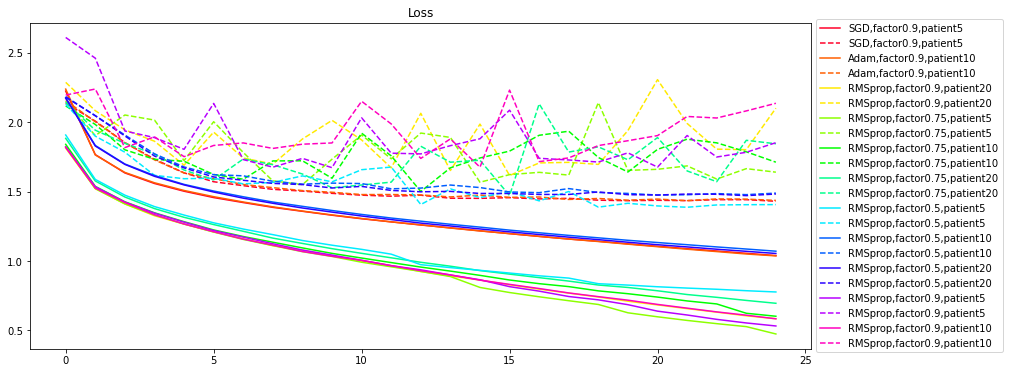

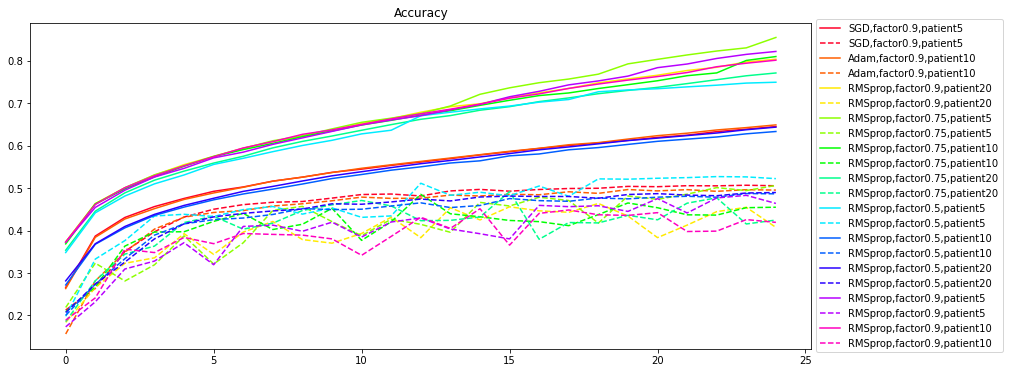

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(14,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(14,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()